# experiment findings

1. outlier handling by dropping columns with zscore adn winsorizing tends to decreasing all the models auc
2. using target encoding in 'pekerjaan' 'column' is slightly increasing the models auc
3. all resampling (oversampling and hybrid) methode from imblearn tends to decreasing all the models auc

# import library

In [1]:
pip install -U scikit-learn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 103.0 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
category-encoders 2.7.0 requires scikit-learn<1.6.0,>=1.0.0, but you have scikit-learn 1.6.1 which is incompatible.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install category-encoders==2.8.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 2.5 MB/s eta 0:00:00
  Attempting uninstall: category-encoders
    Found existing installation: category_encoders 2.7.0
    Uninstalling category_encoders-2.7.0:
      Successfully uninstalled category_encoders-2.7.0
Note: you may need to restart the kernel to use updated packages.


In [3]:
import category_encoders
print(category_encoders.__version__)


2.8.1


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import shap
import category_encoders as ce
import optuna

from scipy.stats import zscore
from scipy.stats.mstats import winsorize

from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import (
    RandomForestClassifier,
    ExtraTreesClassifier,
    GradientBoostingClassifier,
    HistGradientBoostingClassifier,
    BaggingClassifier,
    AdaBoostClassifier
)
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import cross_val_score, StratifiedKFold
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.feature_selection import RFECV, RFE

from imblearn.over_sampling import (
    RandomOverSampler, SMOTE, SMOTENC, SMOTEN, ADASYN,
    BorderlineSMOTE, KMeansSMOTE, SVMSMOTE
)

from imblearn.combine import SMOTEENN, SMOTETomek


pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [5]:
train = pd.read_csv('/kaggle/input/dsi-challenges/training_dataset.csv')

# data understanding

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22916 entries, 0 to 22915
Data columns (total 22 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   customer_number               22916 non-null  int64  
 1   usia                          22916 non-null  int64  
 2   pekerjaan                     22916 non-null  object 
 3   status_perkawinan             22916 non-null  object 
 4   pendidikan                    22916 non-null  object 
 5   gagal_bayar_sebelumnya        22916 non-null  object 
 6   pinjaman_rumah                22916 non-null  object 
 7   pinjaman_pribadi              22916 non-null  object 
 8   jenis_kontak                  22916 non-null  object 
 9   bulan_kontak_terakhir         22916 non-null  object 
 10  hari_kontak_terakhir          22916 non-null  object 
 11  jumlah_kontak_kampanye_ini    22916 non-null  int64  
 12  hari_sejak_kontak_sebelumnya  22916 non-null  int64  
 13  j

In [7]:
train.head()

,customer_number,usia,pekerjaan,status_perkawinan,pendidikan,gagal_bayar_sebelumnya,pinjaman_rumah,pinjaman_pribadi,jenis_kontak,bulan_kontak_terakhir,hari_kontak_terakhir,jumlah_kontak_kampanye_ini,hari_sejak_kontak_sebelumnya,jumlah_kontak_sebelumnya,hasil_kampanye_sebelumnya,tingkat_variasi_pekerjaan,indeks_harga_konsumen,indeks_kepercayaan_konsumen,suku_bunga_euribor_3bln,jumlah_pekerja,pulau,berlangganan_deposito
0,531036,63,sosial media specialis,menikah,Pendidikan Tinggi,no,yes,no,cellular,jul,fri,2,999,0,nonexistent,-1.7,94.215,-40.3,0.885,4991.6,Papua,1
1,999241,43,teknisi,menikah,Pendidikan Tinggi,no,yes,no,cellular,nov,fri,2,999,0,nonexistent,-0.1,93.200,-42.0,4.021,5195.8,Sulawesi,0
2,995002,29,sosial media specialis,lajang,Pendidikan Tinggi,no,yes,yes,cellular,jul,thu,1,999,0,nonexistent,1.4,93.918,-42.7,4.958,5228.1,Papua,0
3,932750,40,pekerja kasar,menikah,SMA,no,no,no,telephone,may,wed,2,999,0,nonexistent,1.1,93.994,-36.4,4.859,5191.0,Sumatera,1
4,684699,40,sosial media specialis,lajang,Pendidikan Tinggi,no,no,no,cellular,aug,wed,3,999,0,nonexistent,1.4,93.444,-36.1,4.964,5228.1,Bali,0


### unique value in object columns

In [8]:
object_cols = train.select_dtypes(include='object')

for col in object_cols.columns:
    print(f"\n--- Distribution for column: {col} ---")
    print(train[col].value_counts(dropna=False))


--- Distribution for column: pekerjaan ---
pekerjaan
sosial media specialis    5755
pekerja kasar             5191
teknisi                   3709
penyedia jasa             2195
manajer                   1653
pensiunan                  968
entrepreneur               815
pemilik bisnis             784
asisten rumah tangga       578
pengangguran               561
mahasiswa                  514
unknown                    193
Name: count, dtype: int64

--- Distribution for column: status_perkawinan ---
status_perkawinan
menikah    13858
lajang      6445
cerai       2566
unknown       47
Name: count, dtype: int64

--- Distribution for column: pendidikan ---
pendidikan
Pendidikan Tinggi    6699
SMA                  5403
SMP                  3337
Diploma              2881
Tidak Tamat SD       2284
SD                   1308
unknown               992
TIDAK SEKOLAH          12
Name: count, dtype: int64

--- Distribution for column: gagal_bayar_sebelumnya ---
gagal_bayar_sebelumnya
no         181

### target distribution

In [9]:
train['berlangganan_deposito'].value_counts()

berlangganan_deposito
0    20302
1     2614
Name: count, dtype: int64

### numerical columns distribution

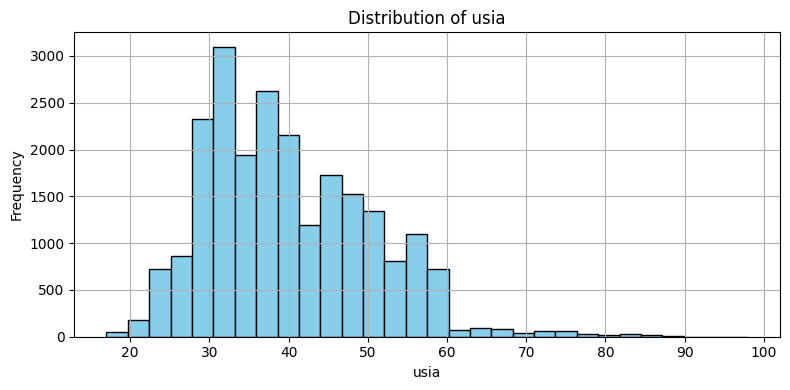

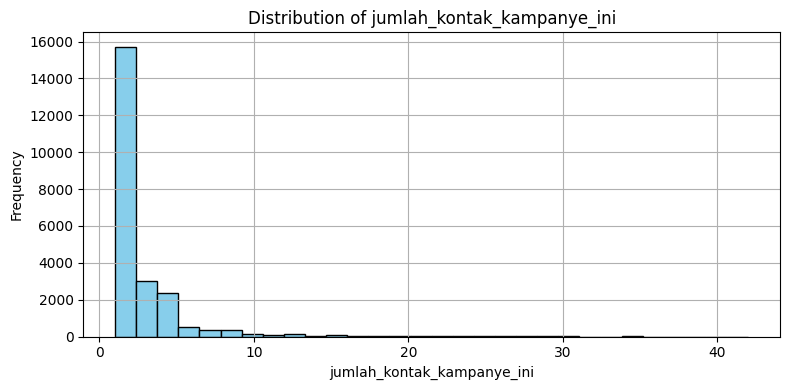

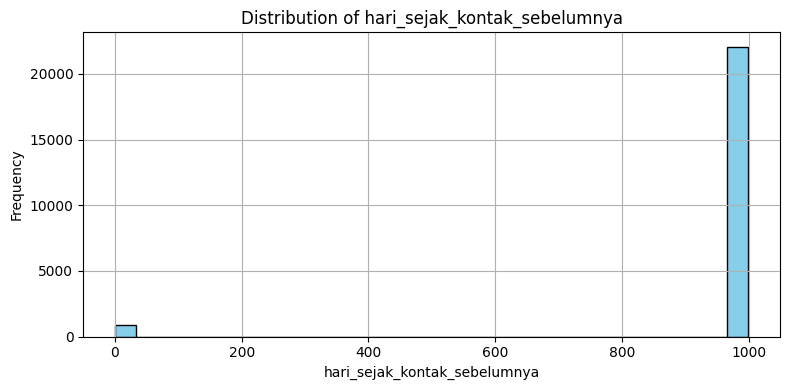

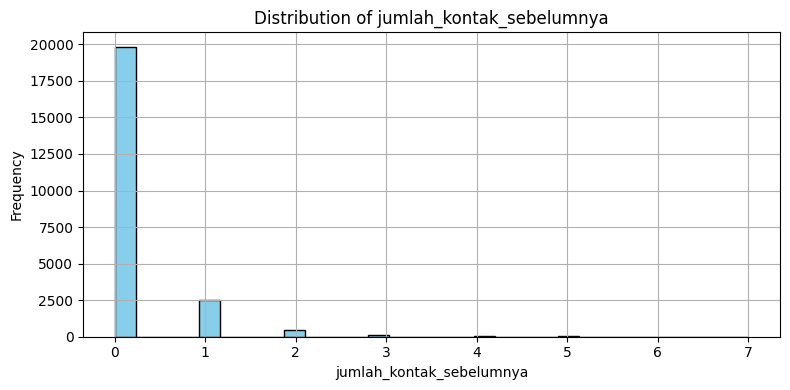

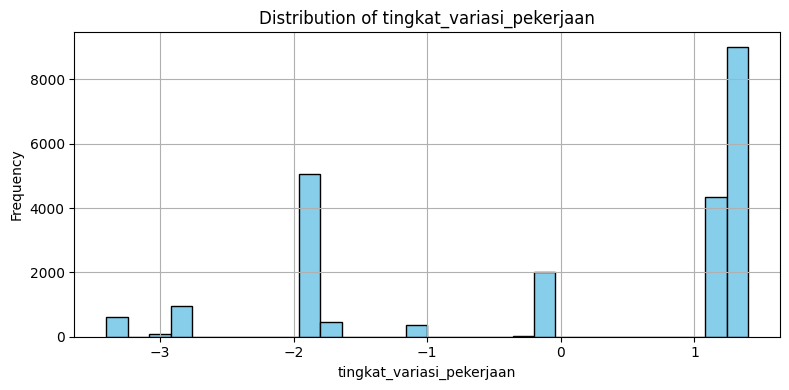

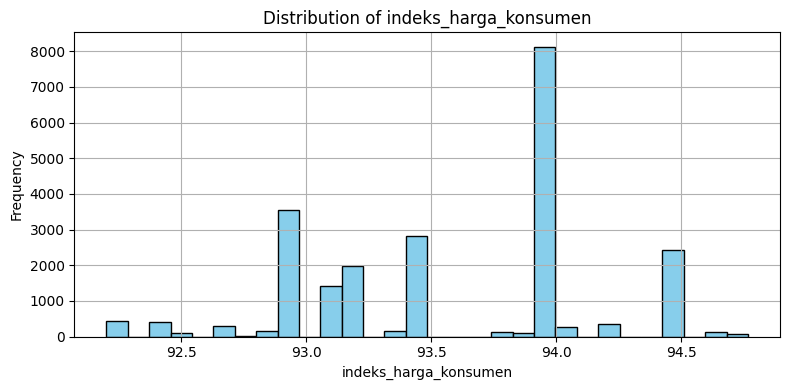

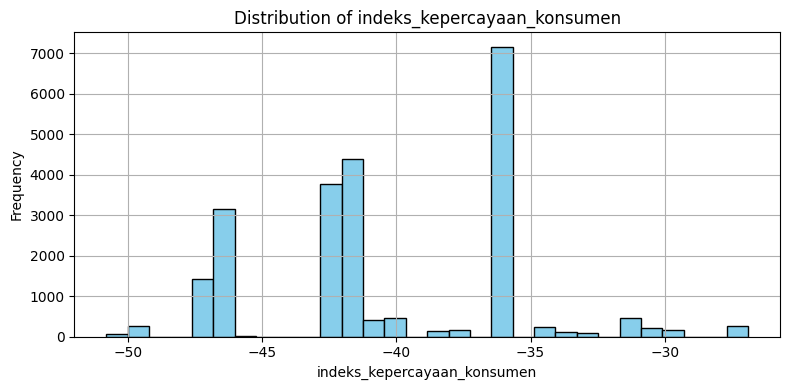

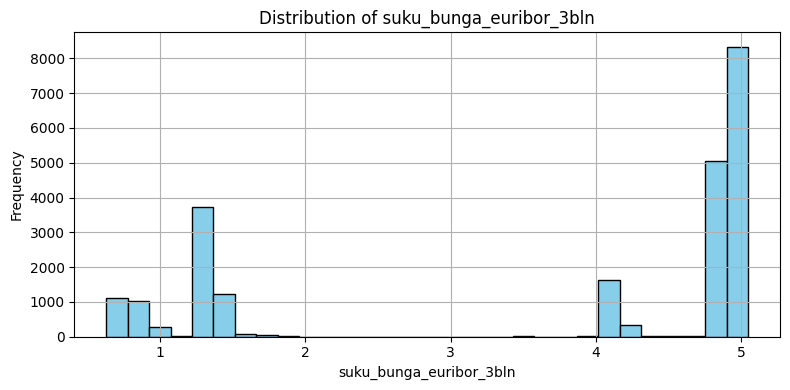

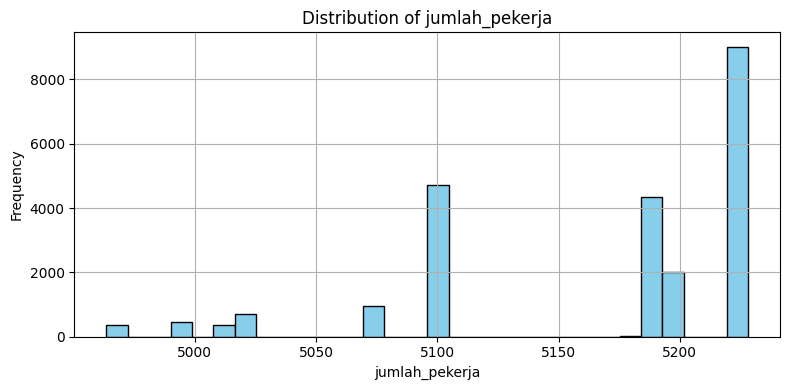

In [10]:
# Define the list of column names to visualize
columns_to_plot = [
    'usia',
    'jumlah_kontak_kampanye_ini',
    'hari_sejak_kontak_sebelumnya',
    'jumlah_kontak_sebelumnya',
    'tingkat_variasi_pekerjaan',
    'indeks_harga_konsumen',
    'indeks_kepercayaan_konsumen',
    'suku_bunga_euribor_3bln',
    'jumlah_pekerja'
]

# Remove duplicates if any
# columns_to_plot = list(dict.fromkeys(columns_to_plot))

# Loop through the column names and plot histograms
for col in columns_to_plot:
    if col in train.columns:
        plt.figure(figsize=(8, 4))
        plt.hist(train[col].dropna(), bins=30, color='skyblue', edgecolor='black')
        plt.title(f'Distribution of {col}')
        plt.xlabel(col)
        plt.ylabel('Frequency')
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    else:
        print(f"Column '{col}' not found in DataFrame")

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.


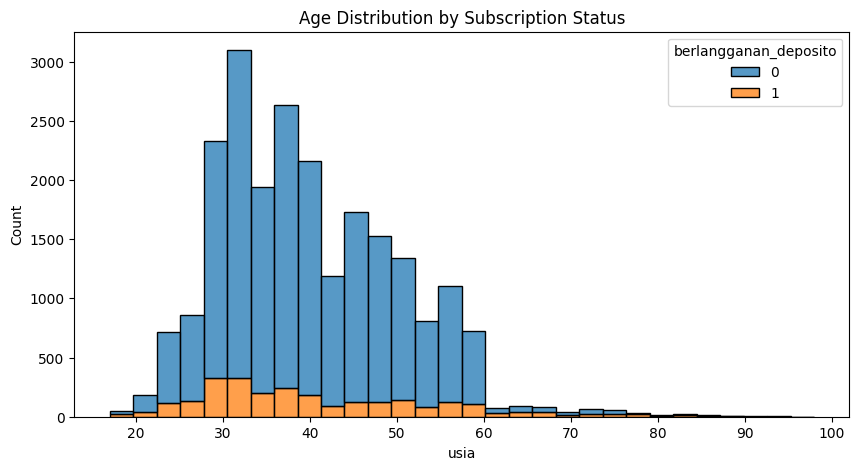

In [11]:
plt.figure(figsize=(10, 5))
sns.histplot(data=train, x='usia', hue='berlangganan_deposito', multiple='stack', bins=30)
plt.title("Age Distribution by Subscription Status")
plt.show()

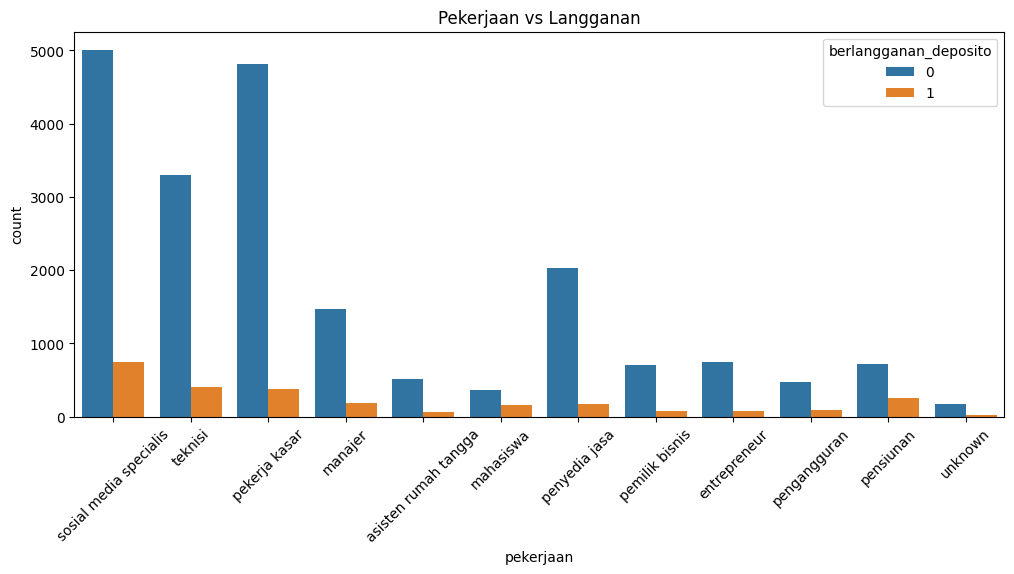

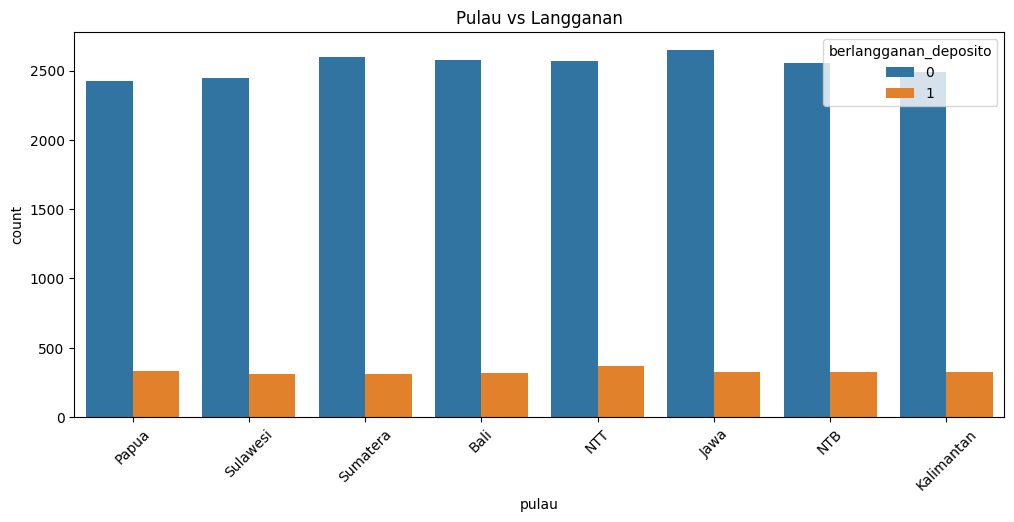

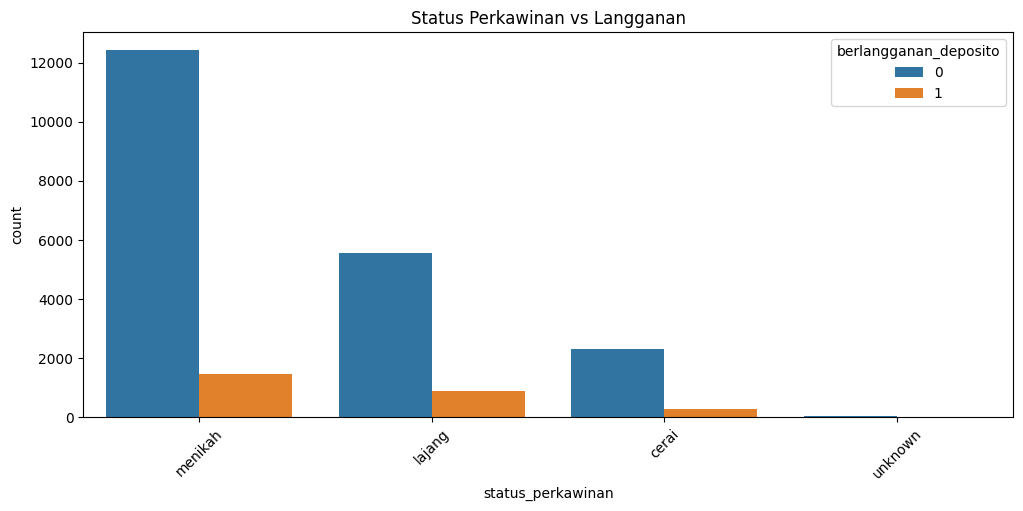

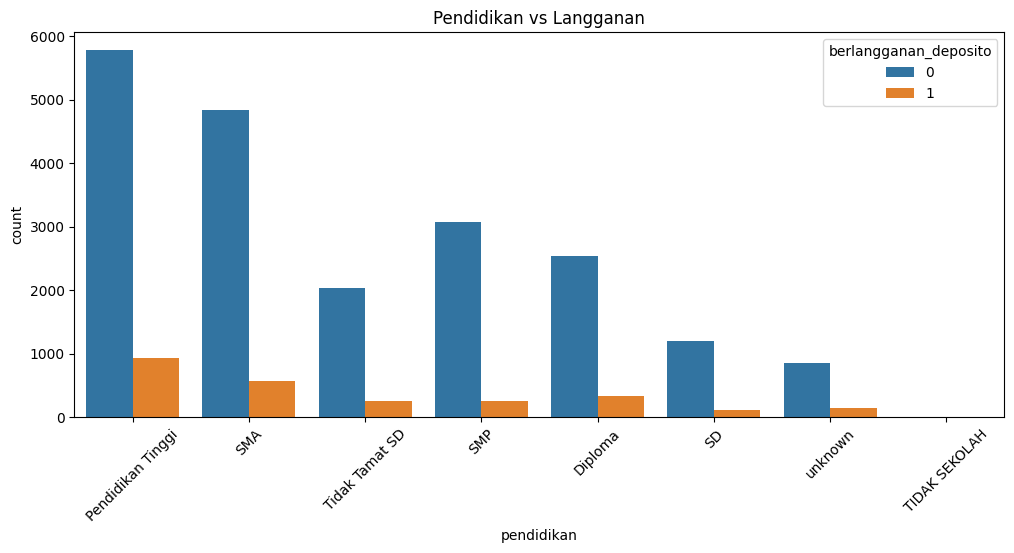

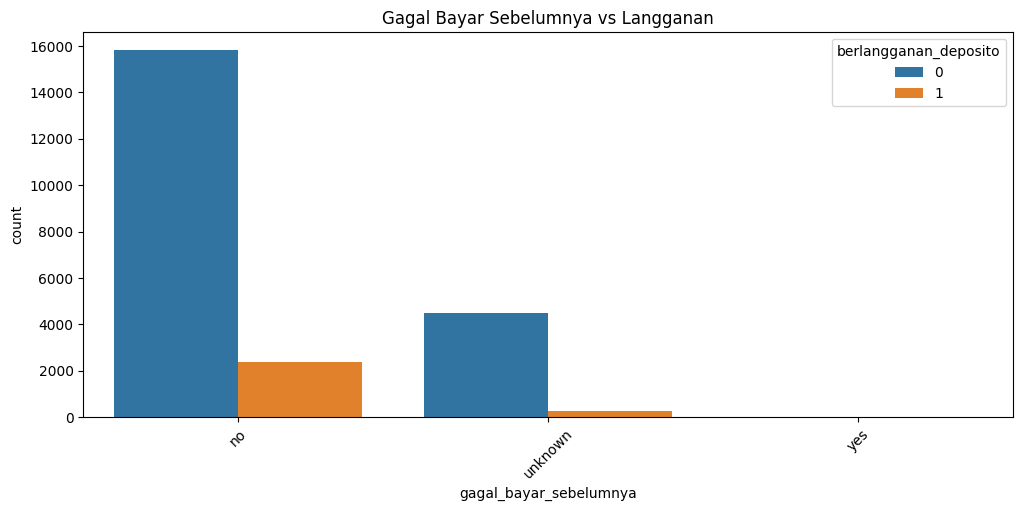

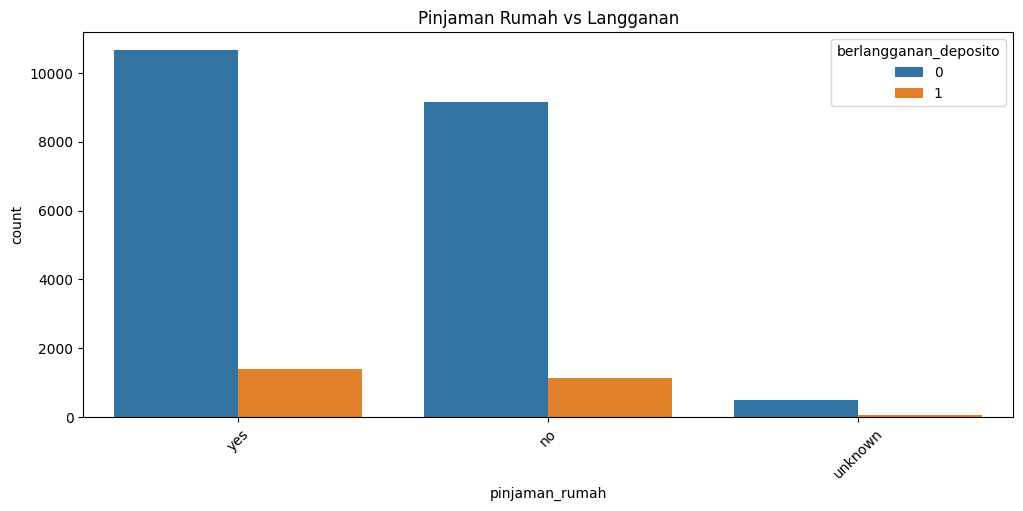

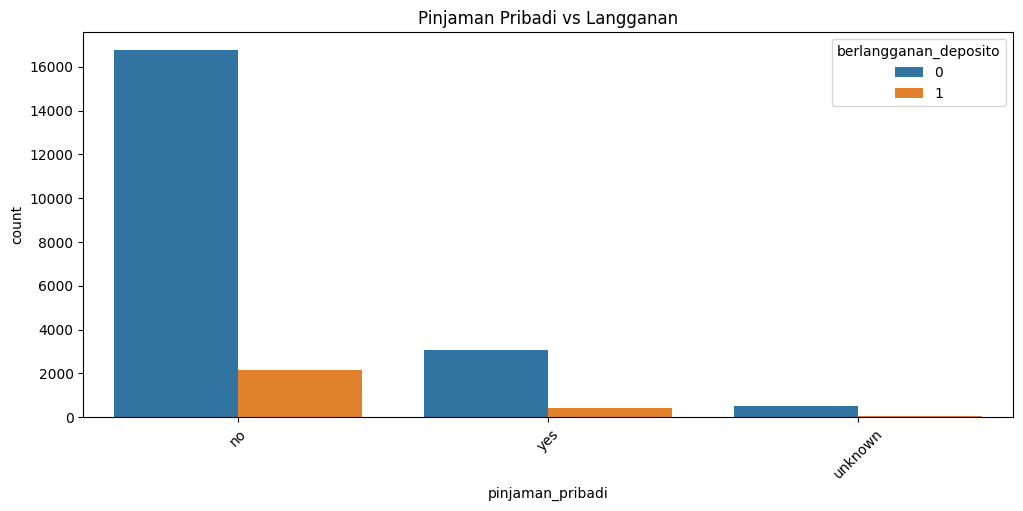

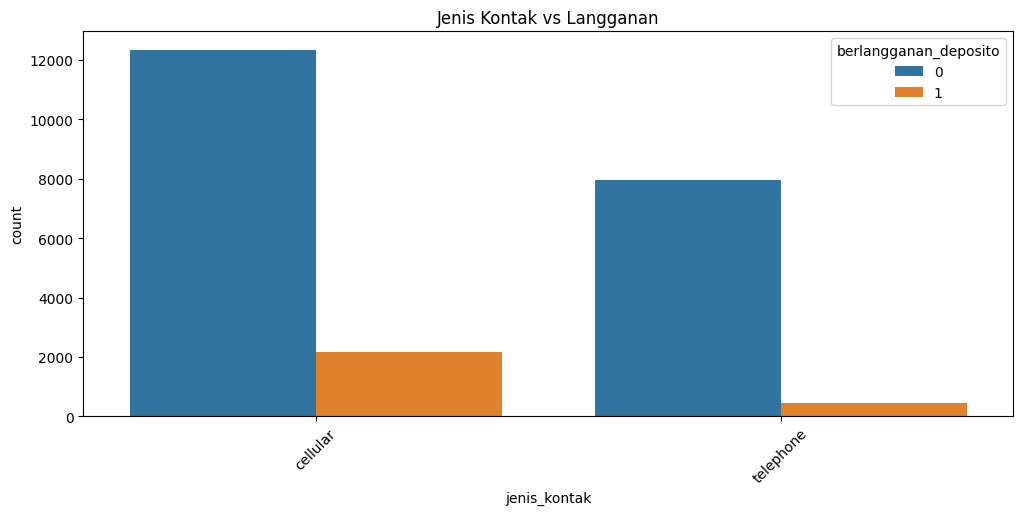

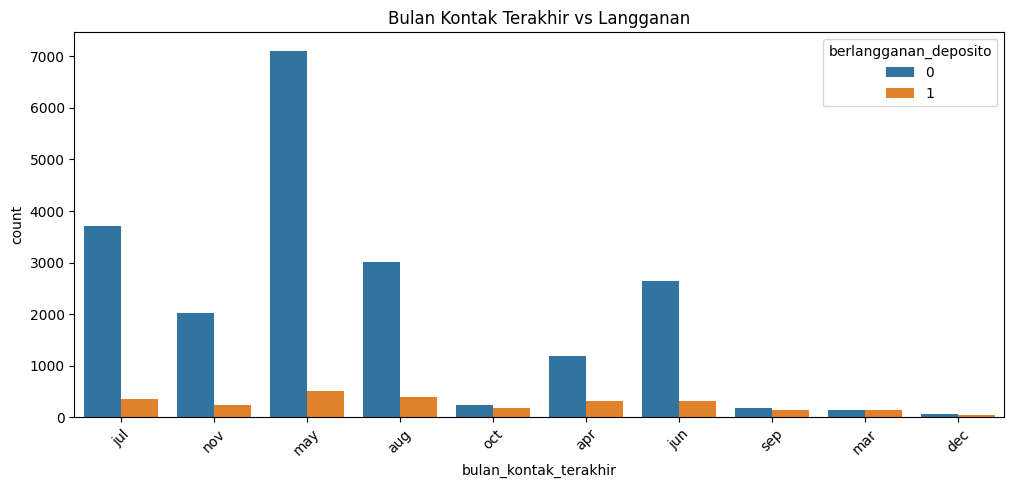

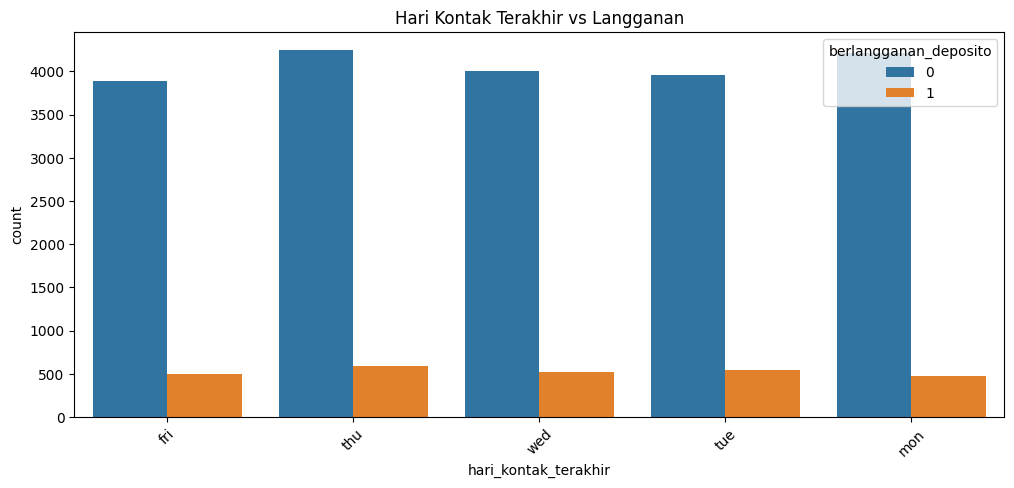

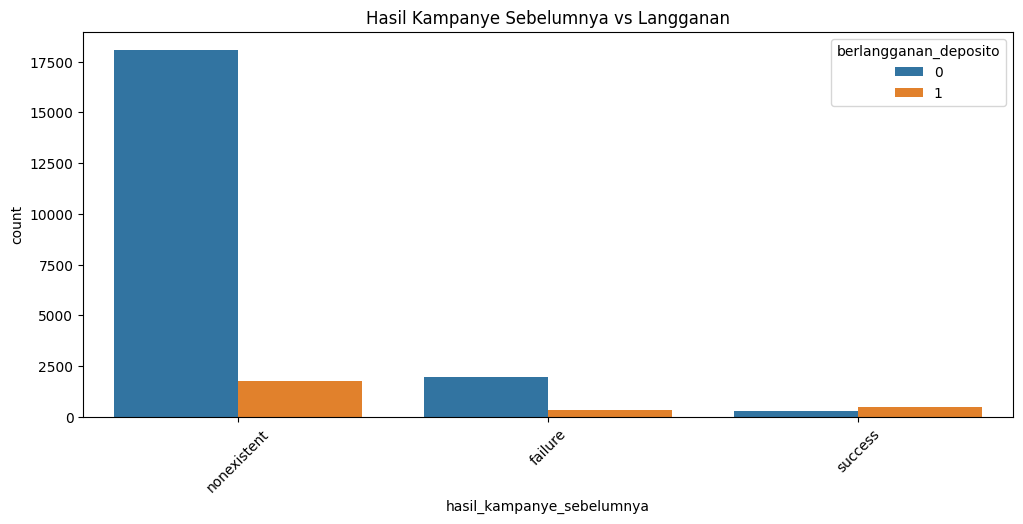

In [12]:
fitur_kategori = ['pekerjaan', 'pulau', 'status_perkawinan', 'pendidikan', 'gagal_bayar_sebelumnya',
                  'pinjaman_rumah', 'pinjaman_pribadi', 'jenis_kontak',
                  'bulan_kontak_terakhir', 'hari_kontak_terakhir', 'hasil_kampanye_sebelumnya']

for fitur in fitur_kategori:
    plt.figure(figsize=(12, 5))
    sns.countplot(data=train, x=fitur, hue='berlangganan_deposito')
    plt.title(f"{fitur.replace('_', ' ').title()} vs Langganan")
    plt.xticks(rotation=45)
    plt.show()

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.


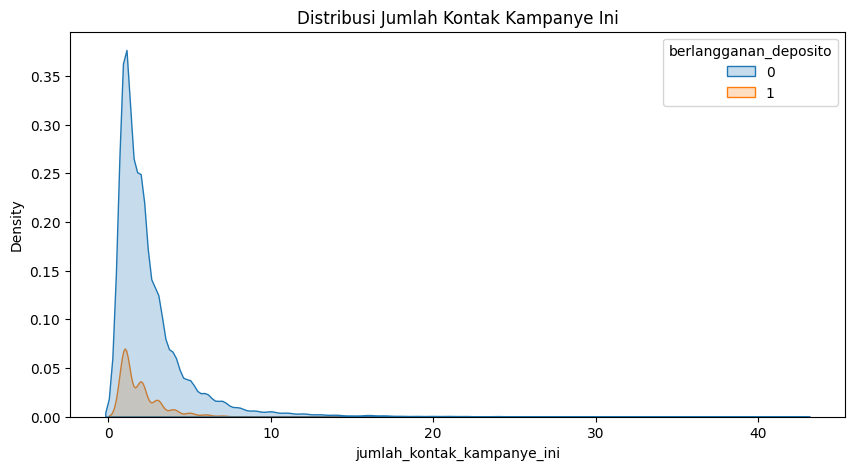

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.


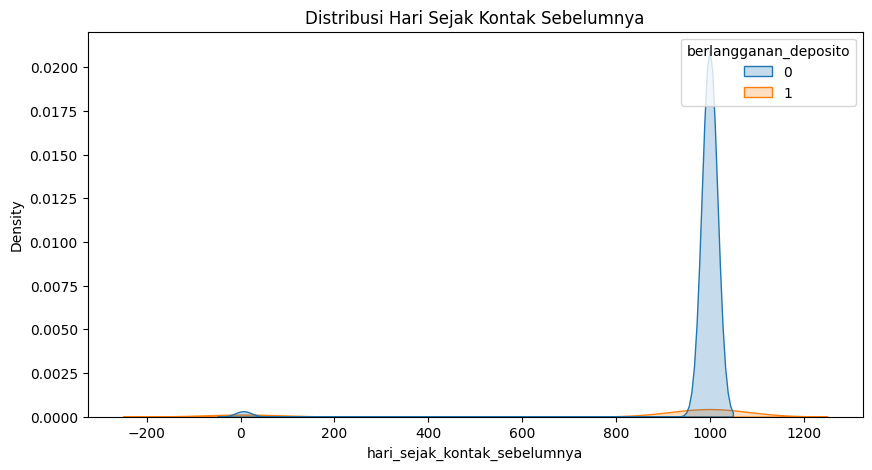

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.


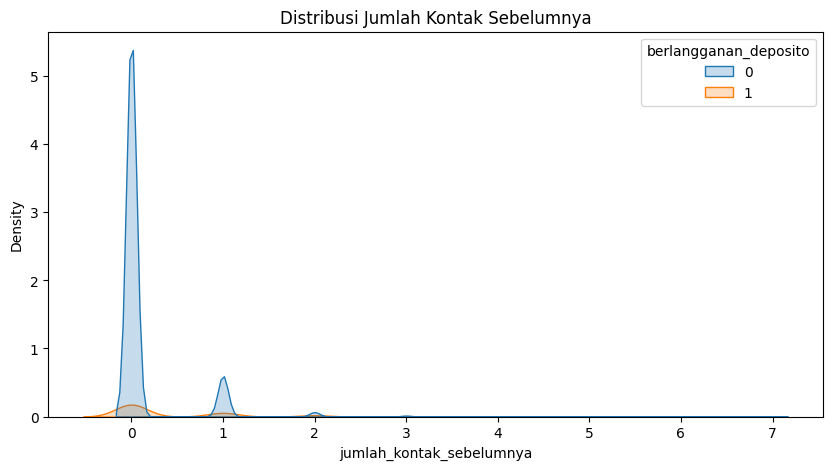

In [13]:
fitur_kampanye = ['jumlah_kontak_kampanye_ini', 'hari_sejak_kontak_sebelumnya', 'jumlah_kontak_sebelumnya']

for fitur in fitur_kampanye:
    plt.figure(figsize=(10, 5))
    sns.kdeplot(data=train, x=fitur, hue='berlangganan_deposito', fill=True)
    plt.title(f"Distribusi {fitur.replace('_', ' ').title()}")
    plt.show()


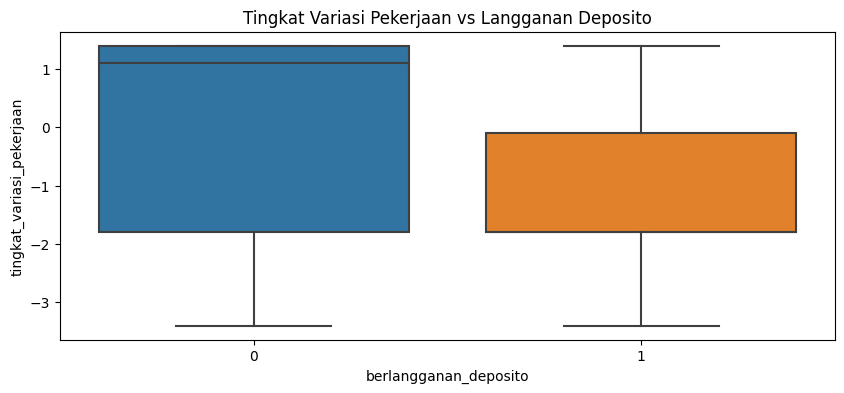

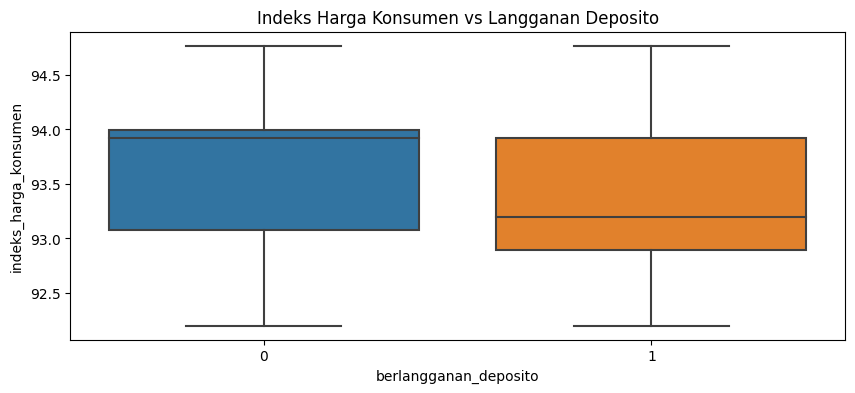

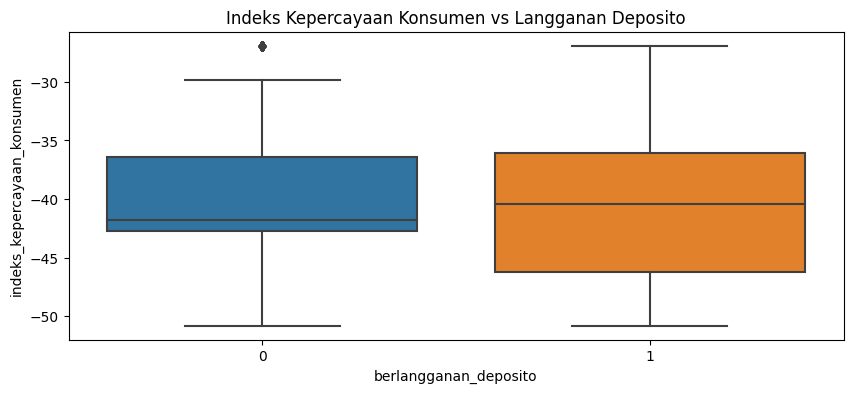

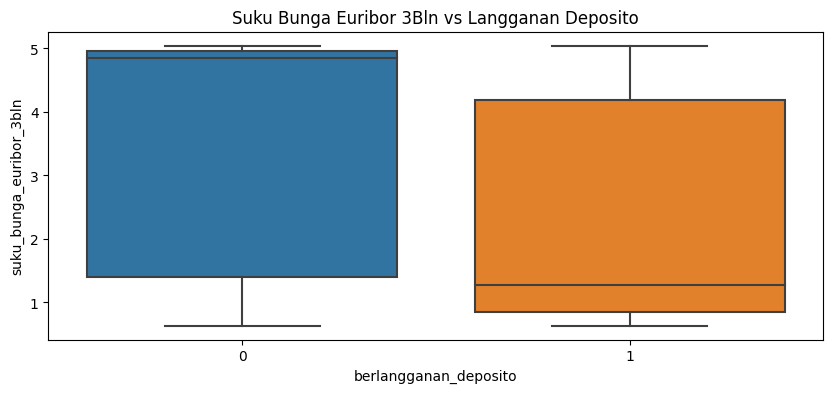

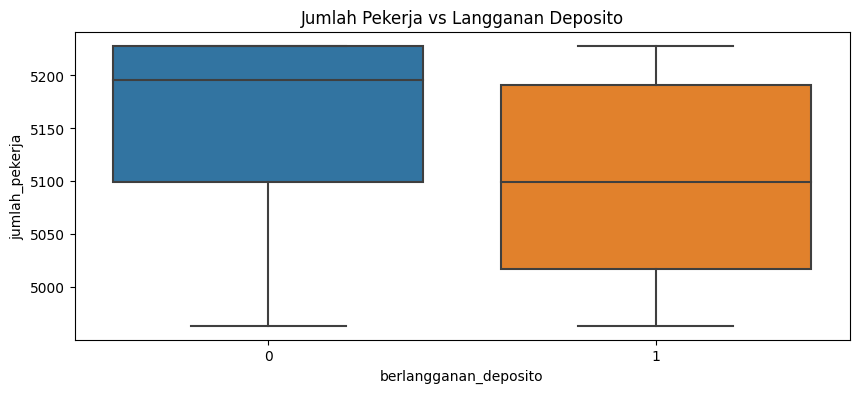

In [14]:
fitur_ekonomi = ['tingkat_variasi_pekerjaan', 'indeks_harga_konsumen',
                 'indeks_kepercayaan_konsumen', 'suku_bunga_euribor_3bln', 'jumlah_pekerja']

for fitur in fitur_ekonomi:
    plt.figure(figsize=(10, 4))
    sns.boxplot(data=train, x='berlangganan_deposito', y=fitur)
    plt.title(f"{fitur.replace('_', ' ').title()} vs Langganan Deposito")
    plt.show()

### correlation

In [15]:
# 1. Correlation matrices
def show_correlations(df):
    correlation_methods = ['pearson', 'kendall', 'spearman']
    
    for method in correlation_methods:
        corr_matrix = df.corr(method=method)
        print(f"\nCorrelation matrix using {method} method:\n")
        # print(corr_matrix)

        # Plot heatmap
        plt.figure(figsize=(10, 8))
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
        plt.title(f'{method.capitalize()} Correlation Matrix')
        plt.show()


# 2. Multicollinearity using VIF
def calculate_vif(df):
    # Add constant for statsmodels
    X = add_constant(df)
    vif_data = pd.DataFrame()
    vif_data['Feature'] = X.columns
    vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    
    return vif_data

# preprocessing

## feature creation

In [16]:
# Jenis kontak: Label Encoding (2 values)
# Mapping manual untuk jenis_kontak
mapping_jenis_kontak = {
    'cellular': 1,
    'telephone': 0
}
train['jenis_kontak_encoded'] = train['jenis_kontak'].map(mapping_jenis_kontak)

### feature interaction

In [17]:
# feature interaction
# Feature 1: Usia x Suku Bunga Euribor
train['usia_euribor_interaction'] = train['usia'] * train['suku_bunga_euribor_3bln']
# Feature 2: Jumlah Pekerja x Suku Bunga Euribor
train['pekerja_euribor_interaction'] = train['jumlah_pekerja'] * train['suku_bunga_euribor_3bln']
# Feature 3: Jumlah Kontak Kampanye x Jenis Kontak
train['kontak_interaction'] = train['jumlah_kontak_kampanye_ini'] * train['jenis_kontak_encoded']

### stabilitas ekonomi

In [18]:
# # Feature 1: inflasi_euribor_ratio = indeks_harga_konsumen / suku_bunga_euribor_3bln
# train['inflasi_euribor_ratio'] = train['indeks_harga_konsumen'] / np.where(
#     train['suku_bunga_euribor_3bln'] == 0, 1e-10, train['suku_bunga_euribor_3bln']
# )

# # Feature 2: stabilitas_ekonomi = (indeks_kepercayaan_konsumen + jumlah_pekerja - suku_bunga_euribor_3bln) / 3
# train['stabilitas_ekonomi'] = (train['indeks_kepercayaan_konsumen'] + 
#                               train['jumlah_pekerja'] - 
#                               train['suku_bunga_euribor_3bln']) / 3

### frekuensi kontak

In [19]:
# # Feature 1: frekuensi_kontak = jumlah_kontak_kampanye_ini / hari_sejak_kontak_sebelumnya
# # Handle the case where hari_sejak_kontak_sebelumnya = 999 (never contacted before)

# train['hari_sejak_kontak_sebelumnya'] = train['hari_sejak_kontak_sebelumnya'] + 1
# train['hari_sejak_kontak_sebelumnya'] = np.where(
#     train['hari_sejak_kontak_sebelumnya'] == 999, 
#     1000,  # Use 1000 as a proxy for "never contacted"
#     train['hari_sejak_kontak_sebelumnya']
# )
# train['frekuensi_kontak'] = train['jumlah_kontak_kampanye_ini'] / train['hari_sejak_kontak_sebelumnya']

In [20]:
# def categorize_season(month):
#     month = month.lower()  # Convert to lowercase to handle case variations
#     if month in ['jan', 'feb', 'mar']:
#         return 'awal_tahun'
#     elif month in ['apr', 'may', 'jun']:
#         return 'pertengahan_tahun'
#     elif month in ['jul', 'aug', 'sep']:
#         return 'musim_libur'
#     elif month in ['oct', 'nov', 'dec']:
#         return 'akhir_tahun'
#     else:
#         return 'unknown'  # Handle unexpected month values

# # Apply the categorization
# train['musim_kontak'] = train['bulan_kontak_terakhir'].apply(categorize_season)

# # Manual encoding: mapping kategori musim ke angka
# musim_mapping = {
#     'awal_tahun': 0,
#     'pertengahan_tahun': 1,
#     'musim_libur': 2,
#     'akhir_tahun': 3,
#     'unknown': -1  # Untuk menangani nilai tak dikenal
# }

# # Terapkan mapping ke kolom 'musim_kontak'
# train['musim_kontak'] = train['musim_kontak'].map(musim_mapping)

### demografi

In [21]:
# Step 3: Create demographic-based feature: kelompok_usia
# Define a function to categorize age into groups
def categorize_age(age):
    if age < 30:
        return 'muda'
    elif 30 <= age <= 45:
        return 'dewasa'
    elif 46 <= age <= 60:
        return 'paruh_baya'
    else:  # age > 60
        return 'lansia'

# Apply the categorization
train['kelompok_usia'] = train['usia'].apply(categorize_age)

# Step 4: Manual encoding for kelompok_usia
# Mapping: muda=0, dewasa=1, paruh_baya=2, lansia=3
kelompok_usia_mapping = {
    'muda': 0,
    'dewasa': 1,
    'paruh_baya': 2,
    'lansia': 3
}
train['kelompok_usia'] = train['kelompok_usia'].map(kelompok_usia_mapping)

In [22]:
# Step 2: Encode the categorical columns using value_counts with scaling (minimum value = 1)
# Value counts provided
status_perkawinan_counts = {'menikah': 13858, 'lajang': 6445, 'cerai': 2566, 'unknown': 47}
pinjaman_rumah_counts = {'yes': 12053, 'no': 10284, 'unknown': 579}
pinjaman_pribadi_counts = {'no': 18888, 'yes': 3449, 'unknown': 579}


status_min = min(status_perkawinan_counts.values())  # 47
status_max = max(status_perkawinan_counts.values())  # 13858
status_perkawinan_mapping = {
    key: 1 + 9 * (value - status_min) / (status_max - status_min)
    for key, value in status_perkawinan_counts.items()
}
train['status_perkawinan'] = train['status_perkawinan'].map(status_perkawinan_mapping)

# Step 2.2: Encode pinjaman_rumah (scale to range 1-5)
rumah_min = min(pinjaman_rumah_counts.values())  # 579
rumah_max = max(pinjaman_rumah_counts.values())  # 12053
pinjaman_rumah_mapping = {
    key: 1 + 4 * (value - rumah_min) / (rumah_max - rumah_min)
    for key, value in pinjaman_rumah_counts.items()
}
train['pinjaman_rumah'] = train['pinjaman_rumah'].map(pinjaman_rumah_mapping)

# Step 2.3: Encode pinjaman_pribadi (scale to range 1-5)
pribadi_min = min(pinjaman_pribadi_counts.values())  # 579
pribadi_max = max(pinjaman_pribadi_counts.values())  # 18888
pinjaman_pribadi_mapping = {
    key: 1 + 4 * (value - pribadi_min) / (pribadi_max - pribadi_min)
    for key, value in pinjaman_pribadi_counts.items()
}
train['pinjaman_pribadi'] = train['pinjaman_pribadi'].map(pinjaman_pribadi_mapping)

In [23]:
# Step 3: Create the interaction feature
# Formula: status_perkawinan_encoded * (pinjaman_rumah_encoded + pinjaman_pribadi_encoded)
train['status_dan_pinjaman'] = train['status_perkawinan'] * (train['pinjaman_rumah'] + train['pinjaman_pribadi'])

### campaign

In [24]:
# # Step 2: Encode the columns using value_counts with scaling (minimum value = 1)
# # Value counts provided
# jumlah_kontak_sebelumnya_counts = {0: 19836, 1: 2495, 2: 418, 3: 115, 4: 41, 5: 8, 6: 2, 7: 1}

# # Step 2.1: Encode jumlah_kontak_sebelumnya (scale to range 1-10)
# kontak_min = min(jumlah_kontak_sebelumnya_counts.values())  # 1
# kontak_max = max(jumlah_kontak_sebelumnya_counts.values())  # 19836
# jumlah_kontak_sebelumnya_mapping = {
#     key: 1 + 9 * (value - kontak_min) / (kontak_max - kontak_min)
#     for key, value in jumlah_kontak_sebelumnya_counts.items()
# }
# train['jumlah_kontak_sebelumnya'] = train['jumlah_kontak_sebelumnya'].map(jumlah_kontak_sebelumnya_mapping)

# # Step 2.2: Encode hasil_kampanye_sebelumnya (binary encoding for success)
# train['hasil_kampanye_sebelumnya_berhasil'] = np.where(train['hasil_kampanye_sebelumnya'] == 'success', 1, 0)

# # Step 3: Create the new feature
# # Formula: rasio_keberhasilan_sebelumnya = hasil_kampanye_sebelumnya_success / jumlah_kontak_sebelumnya_encoded
# train['rasio_keberhasilan_sebelumnya'] = train['hasil_kampanye_sebelumnya_berhasil'] / train['jumlah_kontak_sebelumnya']

## encoding

In [25]:
X = train.drop(columns=['berlangganan_deposito', 'customer_number'])
y = train['berlangganan_deposito']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [26]:
# Define helper function for cyclical encoding
def cyclical_encode(series, order):
    map_dict = {v: i for i, v in enumerate(order)}
    num = series.map(map_dict)
    sin = np.sin(2 * np.pi * num / len(order))
    cos = np.cos(2 * np.pi * num / len(order))
    return sin, cos

In [27]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18332 entries, 19392 to 15795
Data columns (total 26 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   usia                          18332 non-null  int64  
 1   pekerjaan                     18332 non-null  object 
 2   status_perkawinan             18332 non-null  float64
 3   pendidikan                    18332 non-null  object 
 4   gagal_bayar_sebelumnya        18332 non-null  object 
 5   pinjaman_rumah                18332 non-null  float64
 6   pinjaman_pribadi              18332 non-null  float64
 7   jenis_kontak                  18332 non-null  object 
 8   bulan_kontak_terakhir         18332 non-null  object 
 9   hari_kontak_terakhir          18332 non-null  object 
 10  jumlah_kontak_kampanye_ini    18332 non-null  int64  
 11  hari_sejak_kontak_sebelumnya  18332 non-null  int64  
 12  jumlah_kontak_sebelumnya      18332 non-null  int64  
 13  ha

In [28]:
# 2. Encoding on training data

# Pendidikan: Ordinal Encoding
pendidikan_order = ['TIDAK SEKOLAH', 'Tidak Tamat SD', 'SD', 'SMP', 'SMA', 'Diploma', 'Pendidikan Tinggi', 'unknown']
ord_enc_pendidikan = OrdinalEncoder(categories=[pendidikan_order])
X_train['pendidikan_encoded'] = ord_enc_pendidikan.fit_transform(X_train[['pendidikan']])
X_test['pendidikan_encoded'] = ord_enc_pendidikan.transform(X_test[['pendidikan']])

# Hari kontak terakhir: Cyclical Encoding
hari_order = ['mon', 'tue', 'wed', 'thu', 'fri']
X_train['hari_sin'], X_train['hari_cos'] = cyclical_encode(X_train['hari_kontak_terakhir'], hari_order)
X_test['hari_sin'], X_test['hari_cos'] = cyclical_encode(X_test['hari_kontak_terakhir'], hari_order)

# Bulan kontak terakhir: Cyclical encoding
month_order = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']
X_train['bulan_sin'], X_train['bulan_cos'] = cyclical_encode(X_train['bulan_kontak_terakhir'], month_order)
X_test['bulan_sin'], X_test['bulan_cos'] = cyclical_encode(X_test['bulan_kontak_terakhir'], month_order)

# Gagal bayar sebelumnya: Ordinal Encoding
fail_order = ['no', 'unknown', 'yes']
ord_enc_fail = OrdinalEncoder(categories=[fail_order])
X_train['gagal_bayar_encoded'] = ord_enc_fail.fit_transform(X_train[['gagal_bayar_sebelumnya']])
X_test['gagal_bayar_encoded'] = ord_enc_fail.transform(X_test[['gagal_bayar_sebelumnya']])

# One-hot encoding nominal categorical columns (excluding 'pekerjaan' and 'pulau')
# one_hot_cols = ['status_perkawinan', 'pinjaman_rumah', 'pinjaman_pribadi', 'hasil_kampanye_sebelumnya']
# -> buat fitur creation demografi
one_hot_cols = ['hasil_kampanye_sebelumnya'] 
X_train = pd.get_dummies(X_train, columns=one_hot_cols, drop_first=False)
X_test = pd.get_dummies(X_test, columns=one_hot_cols, drop_first=False)

# Align columns to avoid mismatch after one-hot encoding
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

# Target encoding for 'pekerjaan' and 'pulau' using category_encoders
target_enc = ce.TargetEncoder(cols=['pekerjaan', 'pulau'])
X_train[['pekerjaan_encoded', 'pulau_encoded']] = target_enc.fit_transform(X_train[['pekerjaan', 'pulau']], y_train)
X_test[['pekerjaan_encoded', 'pulau_encoded']] = target_enc.transform(X_test[['pekerjaan', 'pulau']])

# Drop original columns now encoded
drop_cols = ['pendidikan', 'hari_kontak_terakhir', 'jenis_kontak',
             'bulan_kontak_terakhir', 'gagal_bayar_sebelumnya', 'pekerjaan', 'pulau']
X_train.drop(columns=drop_cols, inplace=True)
X_test.drop(columns=drop_cols, inplace=True)

# Convert any boolean columns to int
bool_cols_train = X_train.select_dtypes(include='bool').columns
bool_cols_test = X_test.select_dtypes(include='bool').columns

X_train[bool_cols_train] = X_train[bool_cols_train].astype(int)
X_test[bool_cols_test] = X_test[bool_cols_test].astype(int)

In [29]:
# # Assuming y_train is a Series or a single-column DataFrame
# Xy_train = X_train.copy()
# Xy_train['target'] = y_train

# # Then call the correlation function
# show_correlations(Xy_train)

In [30]:
# corr = pd.concat([X_train, y_train.rename('target')], axis=1).corr(method='pearson')
# corr.to_csv('correlation_matrix_pearson.csv')

# corr = pd.concat([X_train, y_train.rename('target')], axis=1).corr(method='kendall')
# corr.to_csv('correlation_matrix_kendall.csv')

# corr = pd.concat([X_train, y_train.rename('target')], axis=1).corr(method='spearman')
# corr.to_csv('correlation_matrix_spearman.csv')

### feature selection

# GNN

In [31]:
pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 18.6 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [32]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18332 entries, 19392 to 15795
Data columns (total 29 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   usia                                   18332 non-null  int64  
 1   status_perkawinan                      18332 non-null  float64
 2   pinjaman_rumah                         18332 non-null  float64
 3   pinjaman_pribadi                       18332 non-null  float64
 4   jumlah_kontak_kampanye_ini             18332 non-null  int64  
 5   hari_sejak_kontak_sebelumnya           18332 non-null  int64  
 6   jumlah_kontak_sebelumnya               18332 non-null  int64  
 7   tingkat_variasi_pekerjaan              18332 non-null  float64
 8   indeks_harga_konsumen                  18332 non-null  float64
 9   indeks_kepercayaan_konsumen            18332 non-null  float64
 10  suku_bunga_euribor_3bln                18332 non-null  float64
 11  jum

In [33]:
import torch; print(torch.__version__)

2.6.0+cu124


In [34]:
import torch

# Check if CUDA is available
print("CUDA available:", torch.cuda.is_available())

# Number of GPUs
print("GPU count:", torch.cuda.device_count())

# Name of the current GPU (if available)
if torch.cuda.is_available():
    print("Current GPU:", torch.cuda.get_device_name(0))


CUDA available: True
GPU count: 2
Current GPU: Tesla T4


In [35]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import roc_auc_score
import numpy as np

# --- Data Preparation ---

# 1. Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 2. Combine train + test
X_all = np.concatenate([X_train_scaled, X_test_scaled], axis=0)
x_all = torch.tensor(X_all, dtype=torch.float)

# 3. Labels
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)
y_all = torch.cat([y_train_tensor, y_test_tensor], dim=0)

# 4. Graph edges using k-NN
k = 100
knn = NearestNeighbors(n_neighbors=k + 1)
knn.fit(X_all)
_, indices = knn.kneighbors(X_all)

edge_index_list = []
for i in range(len(indices)):
    for j in indices[i][1:]:  # skip self-loop
        edge_index_list.append([i, j])
edge_index = torch.tensor(edge_index_list, dtype=torch.long).t().contiguous()

# 5. Build graph data
data = Data(x=x_all, edge_index=edge_index, y=y_all)

# --- GCN Model ---

class GCN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training, p=0.3)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# --- Training Setup ---

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = data.to(device)

model = GCN(input_dim=x_all.shape[1], hidden_dim=64, output_dim=2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

# --- Train ---
model.train()
for epoch in range(200):
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[:len(y_train_tensor)], y_train_tensor.to(device))  # train loss only on train
    loss.backward()
    optimizer.step()
    if epoch % 20 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item():.4f}')

# --- Evaluate ---
model.eval()
with torch.no_grad():
    out = model(data)
    probs = out.exp()  # convert from log-softmax
    probs_test = probs[len(y_train_tensor):, 1]  # class 1 prob
    y_test_pred = probs[len(y_train_tensor):].argmax(dim=1)

    # Accuracy
    acc_test = (y_test_pred.cpu() == y_test_tensor).float().mean().item()
    print(f'Test Accuracy: {acc_test:.4f}')

    # AUC
    auc_score = roc_auc_score(y_test_tensor.cpu().numpy(), probs_test.detach().cpu().numpy())
    print(f'Test AUC: {auc_score:.4f}')


Epoch 0, Loss: 0.8233
Epoch 20, Loss: 0.2996
Epoch 40, Loss: 0.2875
Epoch 60, Loss: 0.2849
Epoch 80, Loss: 0.2836
Epoch 100, Loss: 0.2832
Epoch 120, Loss: 0.2826
Epoch 140, Loss: 0.2820
Epoch 160, Loss: 0.2820
Epoch 180, Loss: 0.2814
Test Accuracy: 0.8981
Test AUC: 0.7895
